<a href="https://colab.research.google.com/github/theadamsabra/Audio-Source-Separation-Undergraduate-Thesis/blob/master/Full_Procedure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DO NOT RUN CELLS AND VIEW CACHED RESULTS

## 0: Package Installation and Imports

In [ ]:
!pip install dsdtools

In [ ]:
import dsdtools
import pandas as pd
import os
import librosa
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1: Exploratory Data Analysis

### 1.1: About DSD100

>The dsd100 is a dataset of 100 full lengths music tracks of different styles along with their isolated drums, bass, vocals and others stems.
> dsd100 contains two folders, a folder with a training set: "train", composed of 50 songs, and a folder with a test set: "test", composed of 50 songs. Supervised approaches should be trained on the training set and tested on both sets.
>For each file, the mixture correspond to the sum of all the signals. All signals are stereophonic and encoded at 44.1kHz.
>> [Source](https://sigsep.github.io/datasets/dsd100.html)

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Thesis/DSD100/'
excel_sheet = '/content/drive/My Drive/Thesis/DSD100/dsd100.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
excel = pd.read_excel(excel_sheet)
excel.head()

Name                 Style Duration
0          Actions - Devil's Words             Power Pop   3'17''
1       Actions - One Minute Smile             Power Pop   2'44''
2     Actions - South Of The Water             Power Pop   3'11''
3  Al James - Schoolboy Facination         Bubblegum Pop   3'21''
4     AM Contra - Heart Peripheral  Electronic Dance Pop   3'30''

### 1.2: Distribution Exploration

Generally, the type of style (or genre) may affect separation due to various instruments being used. However, because of how the dataset was prepared, the targets to separate are drums, bass, vocals and others. Because of this, style is simply a descriptive attribute that will not affect separation.

Instead, we will view the distribution of the length of songs in minutes to get a reasonable assesment of what to expect from the songs. The longer the song, the more data there is. This should intuitively make sense.

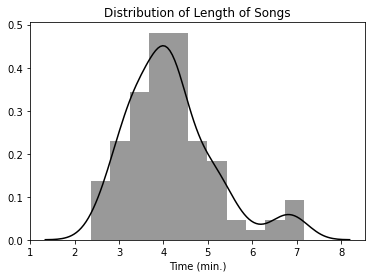

In [ ]:
length = []
# Length is in a string format. 
# The minutes and seconds are parsed and converted into float
for time in excel.Duration:
  min = int(time[0])
  seconds = round(float(int(time[2:4]) / 60), 3) # Rounded to 3 decimal places
  length.append(min + seconds)

plt.title('Distribution of Length of Songs')
sns.distplot(length, color='black', axlabel='Time (min.)')
plt.show()

### 1.3: Visualization of the Time Domain

In this section, we'll play around with visualisations. I will be using one track for simplicity's sake. However, when building the model, all preprocessing will take place within a Keras preprocessing layer.

In [ ]:
dsd = dsdtools.DB(path)
tracks = dsd.load_dsd_tracks('Dev') # Test set
Track = tracks[0] # First song in the test set
audio = Track.audio
rate = Track.rate
vocals = Track.targets['vocals'].audio
time = np.linspace(0, len(audio)/rate , num=len(audio))

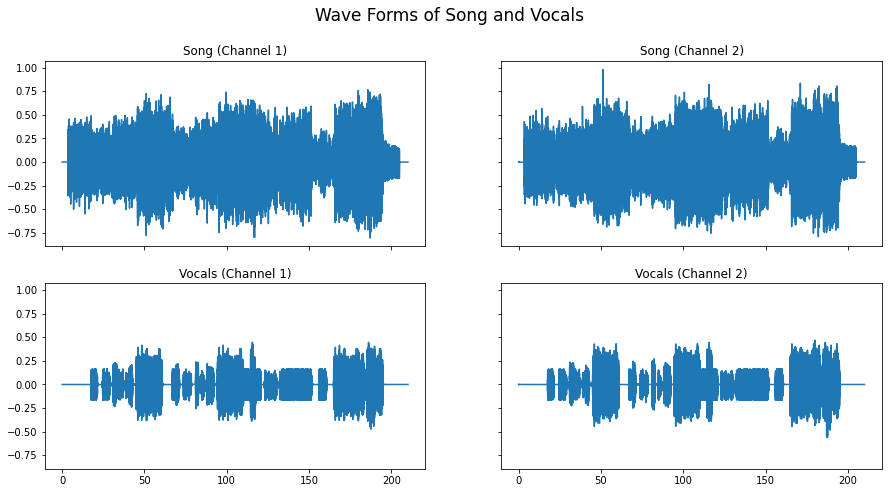

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (15,7.5), sharex=True, sharey=True)
fig.suptitle('Wave Forms of Song and Vocals', fontsize = 17)
ax[0,0].set_title('Song (Channel 1)')
ax[0,0].plot(time, audio[:, 0])
ax[0,1].set_title('Song (Channel 2)')
ax[0,1].plot(time, audio[:, 1])
ax[1,0].set_title('Vocals (Channel 1)')
ax[1,0].plot(time, vocals[:, 0])
ax[1,1].set_title('Vocals (Channel 2)')
ax[1,1].plot(time, vocals[:, 1])

Note that the songs and stems contain 2 channels - or is stereophonic. This does not make working with audio any more/less difficult to process and will actually allow us to utilize more information than a monophonic song - or 1 channel.

Think of a grayscale picture (1 layer) versus a colored picture with RGB (3 layers.)

### 1.4: Visualisation of the Frequency Domain

Now the fun stuff - audio transformations. We transform audio to view the properties of the signals in each song. Signal Processing techniques also help us visualise/paramaterize the signals at each moment in time.

For these visualizations we will be looking at the first channel of the song and vocals. However, when the model undergoes preprocessing, it will use both channels.

#### 1.4.1: Short Time Fourier Transformation

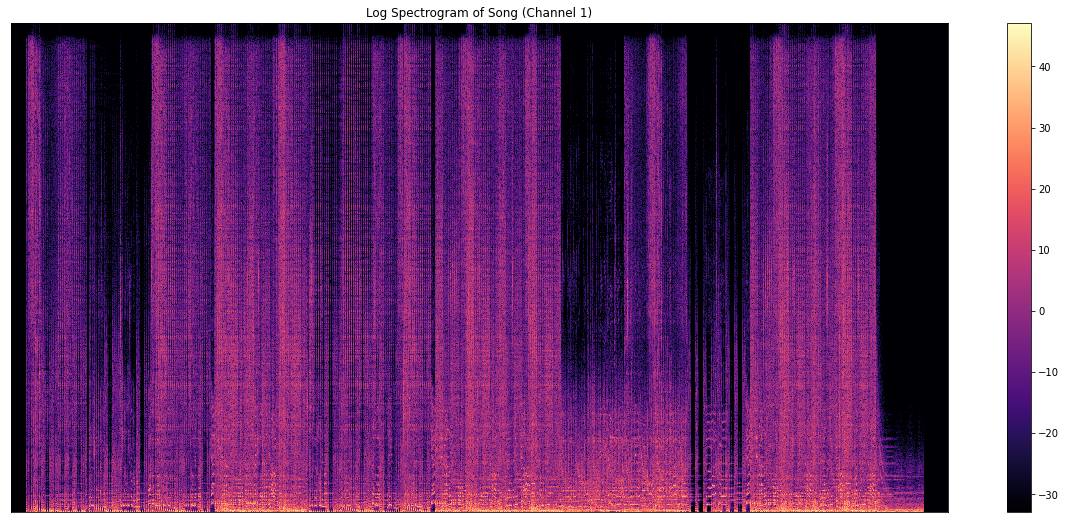

In [ ]:
import librosa.display as ld
hop_length = 512
n_fft = 2048

spec_song = np.abs(librosa.core.stft(audio[:, 0], n_fft = n_fft,
                                     hop_length=hop_length))
log_spec_song = librosa.amplitude_to_db(spec_song)
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('Log Spectrogram of Song (Channel 1)')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ld.specshow(log_spec_song, sr = Track.rate, hop_length=hop_length, 
            cmap = 'magma')
plt.colorbar()
plt.show()

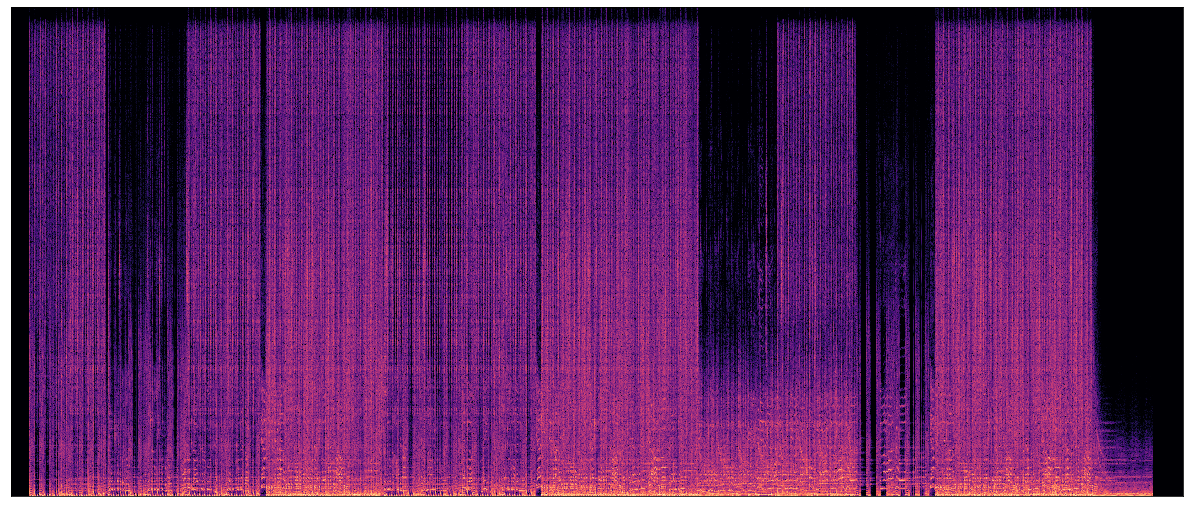

In [ ]:
fig, ax = plt.subplots(figsize = (21,9))
ld.specshow(log_spec_song, sr = Track.rate, hop_length=hop_length, 
            cmap = 'magma')
plt.show()

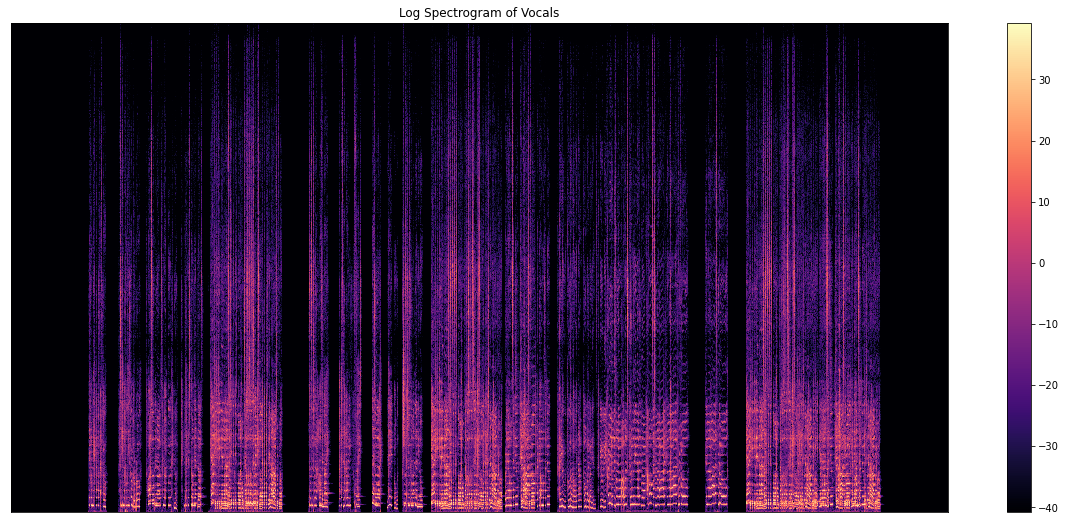

In [ ]:
spec_vocals = np.abs(librosa.core.stft(vocals[:, 0], hop_length = hop_length,
                                       n_fft = n_fft))
log_spec_vocals = librosa.amplitude_to_db(spec_vocals)
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('Log Spectrogram of Vocals')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ld.specshow(log_spec_vocals, sr = Track.rate, hop_length=hop_length, 
            cmap = 'magma')
plt.colorbar()
plt.show()

#### 1.4.2: MFCCs

In [ ]:
MFCC_audio = librosa.feature.mfcc(audio[:, 0], n_fft=n_fft, 
                                   hop_length=hop_length, sr=Track.rate, 
                                   n_mfcc = 13)

MFCC_vocals = librosa.feature.mfcc(vocals[:, 0], n_fft=n_fft, 
                                   hop_length=hop_length, sr=Track.rate, 
                                   n_mfcc = 13)

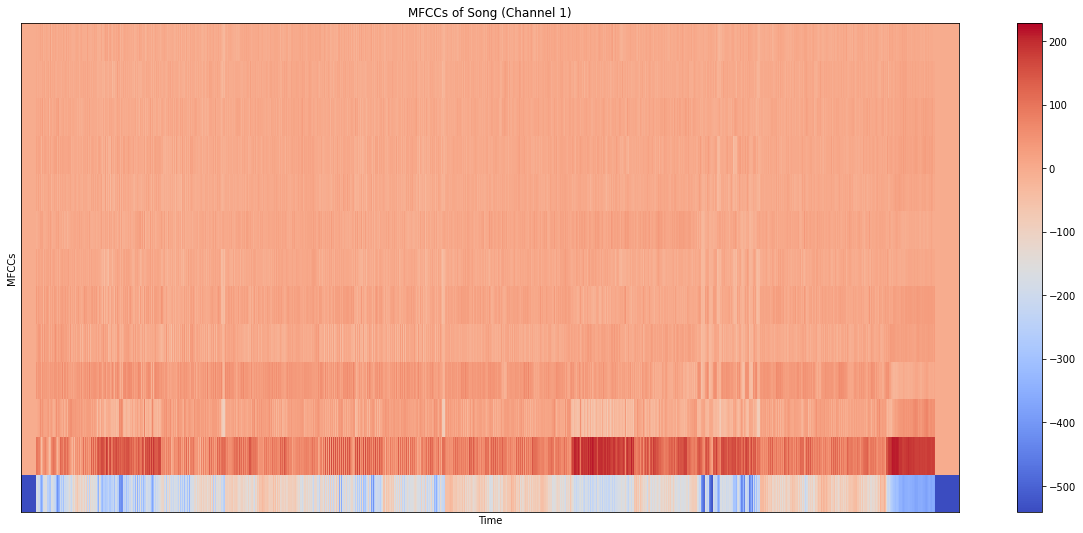

In [ ]:
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('MFCCs of Song (Channel 1)')
ld.specshow(MFCC_audio, sr = Track.rate, hop_length=hop_length)
ax.set_xlabel('Time')
ax.set_ylabel('MFCCs')
plt.colorbar()
plt.show()

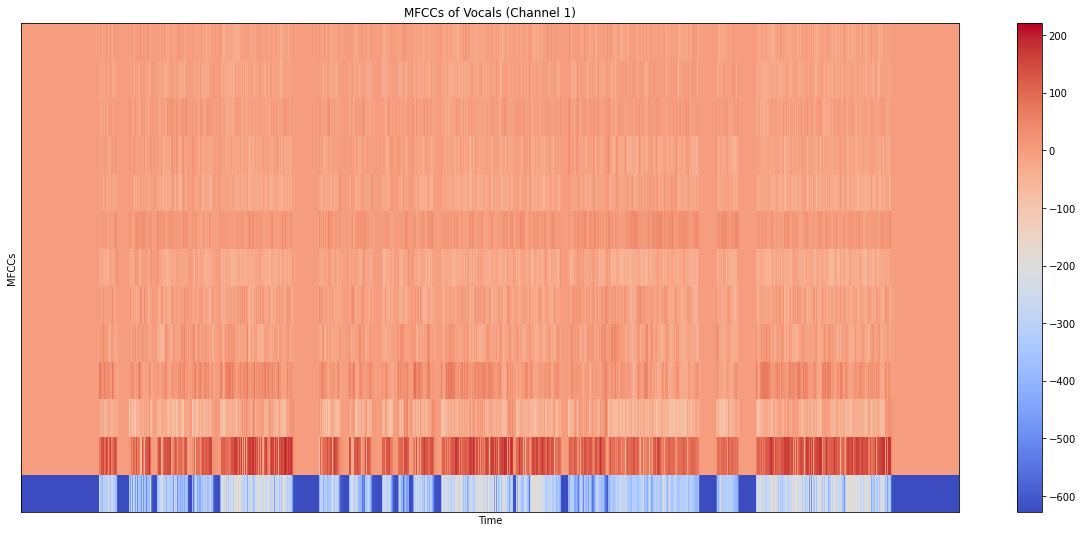

In [ ]:
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('MFCCs of Vocals (Channel 1)')
ld.specshow(MFCC_vocals, sr = Track.rate, hop_length=hop_length)
ax.set_xlabel('Time')
ax.set_ylabel('MFCCs')
plt.colorbar()
plt.show()

## 2: Data Preparation

In [ ]:
'''
SOME NOTES:

IMPORTANT: dsdtools is a parser for the dataset I'm using. I have to keep 
functions consistent with the requirements of the package.

def function(Track):
  operations here
  return {
    whatever you want: has to be dictionary though
  }

When I complete this project, I will rewrite the functions to allow for actual
filetypes.

100 songs split up into 100 segments -> 10000 total segments

Ratio of test/train/val?
Test -> 60%
Train -> 20%
Val -> 20%

We will then find the MFCC of those 10000 segments within the model and save it 
to the data folder.

Once this notebook is complete, I'll then be able to create a repository with
the structure below:

  | - notebooks
    | - CNN_Notes.ipynb
    | - Full_Procedure.ipynb
  | - preprocess.py
  | - model.py
  | - eval.py
  | - requirements.txt
  | - data -> won't upload this for useage issues
      | - test
      | - train
      | - val
''';

In [ ]:
'''

Testing functions below on third segment of song we've been playing with above.
This allows me to test all sorts of possibilites in the function as well as not
have to deal with the loop every time I test the procedure.

'''

n_fft = 2048
n_mfcc = 13
hop_length = 512
num_segments = 100
segment = 3
num_segments = 100
num_chan = Track.audio.shape[1]
samp_per_segment = int(Track.audio.shape[0] / num_segments)
start = samp_per_segment * segment
end = start + samp_per_segment
mfcc_mix1 = librosa.feature.mfcc(Track.audio[start:end, 0], sr = Track.rate,
                                  n_fft = n_fft, n_mfcc = n_mfcc, 
                                  hop_length = hop_length
                                  ).T
mfcc_mix2 = librosa.feature.mfcc(Track.audio[start:end, 1], sr = Track.rate,
                                  n_fft = n_fft, n_mfcc = n_mfcc, 
                                  hop_length = hop_length
                                  ).T
mfcc_mix = np.hstack((mfcc_mix1, mfcc_mix2)).reshape(mfcc_mix1.shape[0],
                                                     mfcc_mix1.shape[1],
                                                     num_chan)
mfcc_voc1 = librosa.feature.mfcc(vocals[start:end, 0], 
                                  sr = Track.rate, n_fft = n_fft, 
                                  n_mfcc = n_mfcc, hop_length = hop_length
                                  ).T
mfcc_voc2 = librosa.feature.mfcc(vocals[start:end, 1],
                                  sr = Track.rate, n_fft = n_fft, 
                                  n_mfcc = n_mfcc, hop_length = hop_length
                                  ).T
mfcc_voc = np.hstack((mfcc_voc1, mfcc_voc2)).reshape(mfcc_voc1.shape[0],
                                                      mfcc_voc1.shape[1],
                                                      num_chan) 

print(mfcc_mix.shape, mfcc_voc.shape) # Perfect!

(181, 13, 2) (181, 13, 2)


In [ ]:
def save_mfcc(Track):
  # Would set these as parameters - however, I'm currently keeping consistent
  # with dsdtools. 
  n_fft = 2048
  n_mfcc = 13
  hop_length = 512
  num_segments = 100
  num_chan = Track.audio.shape[1]
  samp_per_segment = int(Track.audio.shape[0] / num_segments)
  # Expected value of len of segments. Ignore if it's shorter
  Elen = math.ceil(samp_per_segment / hop_length)
  # Dictionary that will be returned.
  data = {
      'Mix MFCC': [],
      'Vocal MFCC': []
  }
  for segment in range(num_segments):
    # Start and end of slice of song
    start = samp_per_segment * segment
    end = start + samp_per_segment
    # Will find MFCC of individual channels then stack as one song.
    # This can and will be generalized further for as many channels as we want.
    # Mix:
    mfcc_mix1 = librosa.feature.mfcc(Track.audio[start:end, 0], sr = Track.rate,
                                     n_fft = n_fft, n_mfcc = n_mfcc, 
                                     hop_length = hop_length
                                     ).T
    mfcc_mix2 = librosa.feature.mfcc(Track.audio[start:end, 1], sr = Track.rate,
                                     n_fft = n_fft, n_mfcc = n_mfcc, 
                                     hop_length = hop_length
                                     ).T
    mfcc_mix = np.hstack((mfcc_mix1, mfcc_mix2)).reshape(mfcc_mix1.shape[0],
                                                         mfcc_mix1.shape[1],
                                                         num_chan)
    if len(mfcc_mix) == Elen:
      data['Mix MFCC'].append(mfcc_mix.tolist())
    # Vocals:
    mfcc_voc1 = librosa.feature.mfcc(
        Track.targets['vocals'].audio[start:end, 0], 
        sr = Track.rate, n_fft = n_fft, 
        n_mfcc = n_mfcc, hop_length = hop_length
        ).T
    mfcc_voc2 = librosa.feature.mfcc(
        Track.targets['vocals'].audio[start:end, 1],
        sr = Track.rate, n_fft = n_fft, 
        n_mfcc = n_mfcc, hop_length = hop_length
        ).T
    mfcc_voc = np.hstack((mfcc_voc1, mfcc_voc2)).reshape(mfcc_voc1.shape[0],
                                                         mfcc_voc1.shape[1],
                                                         num_chan)
    if len(mfcc_voc) == Elen:
      data['Vocal MFCC'].append(mfcc_voc.tolist())
    return data

In [ ]:
Track.targets['vocals'].audio[start:end, 0]

array([0.00000000e+00, 3.05175781e-05, 3.05175781e-05, ...,
       3.05175781e-05, 0.00000000e+00, 0.00000000e+00])

In [ ]:
dsd = dsdtools.DB('/content/drive/My Drive/Thesis/DSD100')
dsd.test(save_mfcc) 

'''
It's working in the cell above but not when we test the function. Look into why
this is happening.
'''

TypeError: ignored